## Examples of how to use the optimization class

First lets import all the modules needed and generate a solver object

In [1]:
import os
os.chdir('..')
os.chdir('..')
print(os.getcwd())
import rsnapsim as rss
import numpy as np
os.chdir('rsnapsim')
os.chdir('interactive_notebooks')


import matplotlib.pyplot as plt
import time


poi_strs, poi_objs, tagged_pois,seq = rss.seqmanip.open_seq_file('../gene_files/Bactin_withTags.txt')
Bactin_obj = tagged_pois['1'][0]

rss.solver.protein = Bactin_obj #pass the protein object
t = np.linspace(0,1000,1001)
solution = rss.solver.solve_ssa(Bactin_obj.kelong, t, ki=.033, kt = 10, low_memory=False,record_stats=True)
solver = rss.solver



C:\Users\willi\Documents\GitHub\rSNAPsim
importing C++ models
c++ models loaded successfully
importing C++ models
c++ models loaded successfully


In [2]:
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False



### Lets generate a simulated data object with a specific parameter set




dict_keys(['ragged', 'head', 'ssa_obj', 'intensity_vec', 'times', 'I_mu', 'I_var'])


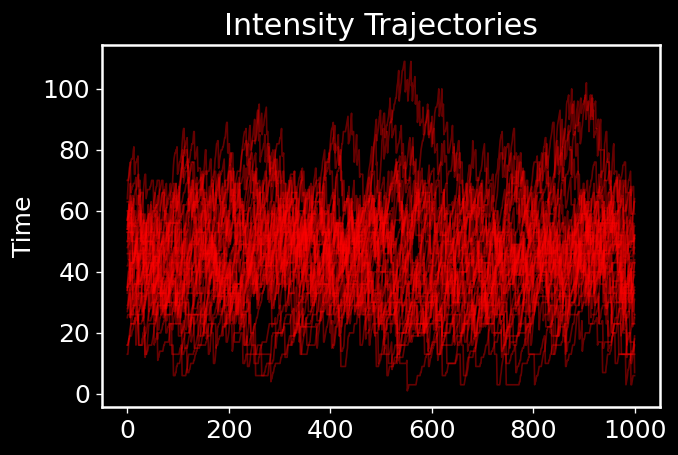

In [3]:
ki = [.08]
ke = [ 5]
colors = ['r']
i = 0
      
Bactin_obj.ke_mu = ke[i] #set the protein object average kelong
solver.default_conditions['burnin'] = 1000 #lets burnin for 1000s
solver.t = np.linspace(0,2000,2001)
solver.n_traj = 30
      
t = np.linspace(0,2000,2001)
ssa_soln = solver.solve_ssa( Bactin_obj.kelong,t, kt=10, ki= ki[0],n_traj=30)  
      
plt.plot(ssa_soln.intensity_vec[0],color=colors[i],alpha=.4)
plt.title('Intensity Trajectories')
plt.ylabel('Time')      
      
    
    

sim_data = rss.optimizer.IntensityData()      #create a new data object
sim_data.add_data(ssa_soln.time,ssa_soln.intensity_vec) #add some intensity data to it
sim_data.get_stats()  #generate stats such as intensity mu and var

print(sim_data.__dict__.keys())


Text(0, 0.5, 'Time')

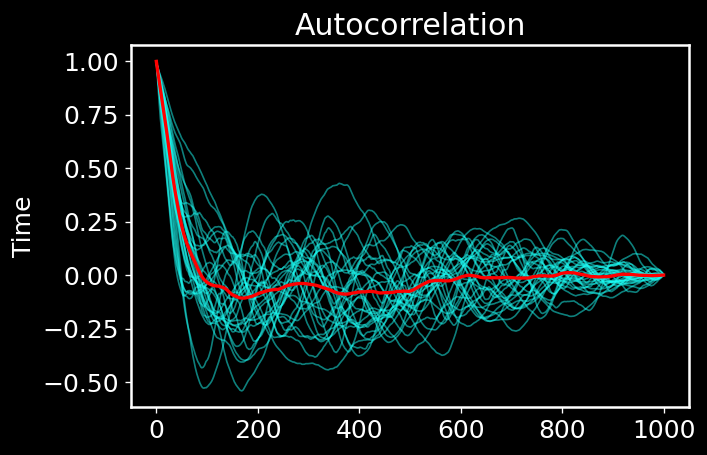

In [4]:
      
sim_acov, sim_acov_err = rss.inta.get_autocov(sim_data.intensity_vec,norm='ind')
sim_acc, sim_acc_err = rss.inta.get_autocorr(sim_acov)
sim_data.acorr = sim_acc
sim_data.acorr_err = sim_acc_err
sim_data.histogram = np.histogram(sim_data.intensity_vec,bins=30)[0]
sim_data.histogram_bins = np.histogram(sim_data.intensity_vec,bins=30)[1]



plt.figure()
plt.plot(sim_data.times[:1001],sim_data.acorr[0], alpha=.5,color='#1cfff7')
plt.plot(sim_data.times[:1001],np.mean(sim_data.acorr[0],axis=1),color='r',lw=2)

plt.title('Autocorrelation')
plt.ylabel('Time')



#### Now we can create an optimization instance 

To run the optimizer, we must pass it a solver object and a datat object.

Objective function arguments are set and accessed before running the optimization


In [5]:
opt = rss.optimizer.TranslationOptimization()  #Optimization object
opt.solver_obj = solver
opt.data_obj = sim_data
opt.parnames = ['ki','ke']
true_par = [.08,5]


opt.opts['bounds'] = ([0.01,.17],[0.1,12])

opt.initial_params = np.array([.033,10])
opt.params = np.array([.033,10])
opt.args['LL_acorr'] = (200,'ind','G0')
opt.args['LL_I_distb'] = (1,)
opt.run_optimization('LL_I_distb','MH',stepsize=[.1,.1],disp=True,mut_rate=.5,logspace=True,niter=500)


Burning in....
current iteration: 50 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 100 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 150 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 200 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 250 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 300 out of 500 | best_parameters: [-1.2561892369107512, 0.5606832676961618] | best evaulation: 126686.496748
current iteration: 350 out of 500 | best_parameters: [-1.2392940145972242, 0.5447045867803593] | best evaulation: 126672.138014
current iteration: 400 out of 500 | best_parameters: [-1.2392940145972242, 0.5447045867803

-133637.2142542929

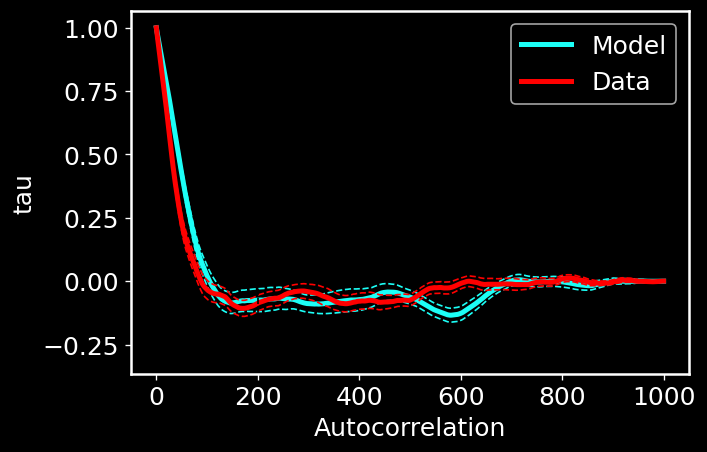

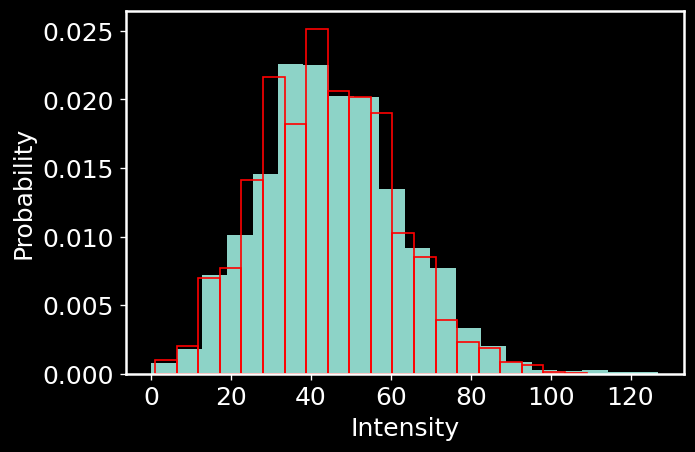

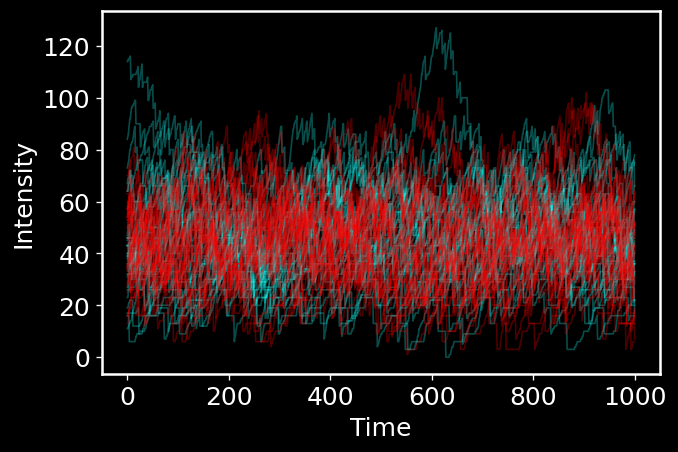

In [6]:

chain = opt.chain
intensity = opt.intensity_fun(chain.bestpar)
fit_acorr,fit_acorr_error = opt.autocorrelation_fun(intensity)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'#1cfff7',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'--', color = '#1cfff7',label='_nolegend_')
plt.plot(fit_acorr+fit_acorr_error[0],'--', color = '#1cfff7',label='_nolegend_')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1,label='_nolegend_')
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1,label='_nolegend_')

plt.plot([200,200],[-.3,1],'k--')
plt.legend(['Model','Data'])
plt.ylabel('tau')
plt.xlabel('Autocorrelation')

plt.figure()
int_hist = opt.intensity_distribution(intensity,bins = sim_data.histogram_bins)
counts1, bins = np.histogram(intensity,density=True,bins=20)
plt.hist(bins[:-1], bins, weights=counts1)

counts2, bins = np.histogram(sim_data.intensity_vec,density=True,bins=20)
counts3, bins3 = np.histogram(sim_data.intensity_vec,bins=20)
plt.hist(bins3[:-1], bins3, weights=counts2,fill=False,edgecolor='r')
plt.ylabel('Probability')
plt.xlabel('Intensity')

plt.figure()
plt.plot(intensity[0],'#1cfff7',alpha=.3)
plt.plot(sim_data.intensity_vec[0],'r',alpha=.3)


plt.xlabel('Time')
plt.ylabel('Intensity')

np.dot(counts3,np.log(counts1))
#np.sum(np.log(counts3*counts1))


C:\Users\willi\Documents\GitHub\rSNAPsim\rsnapsim\TranslationOptimization.py:855: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


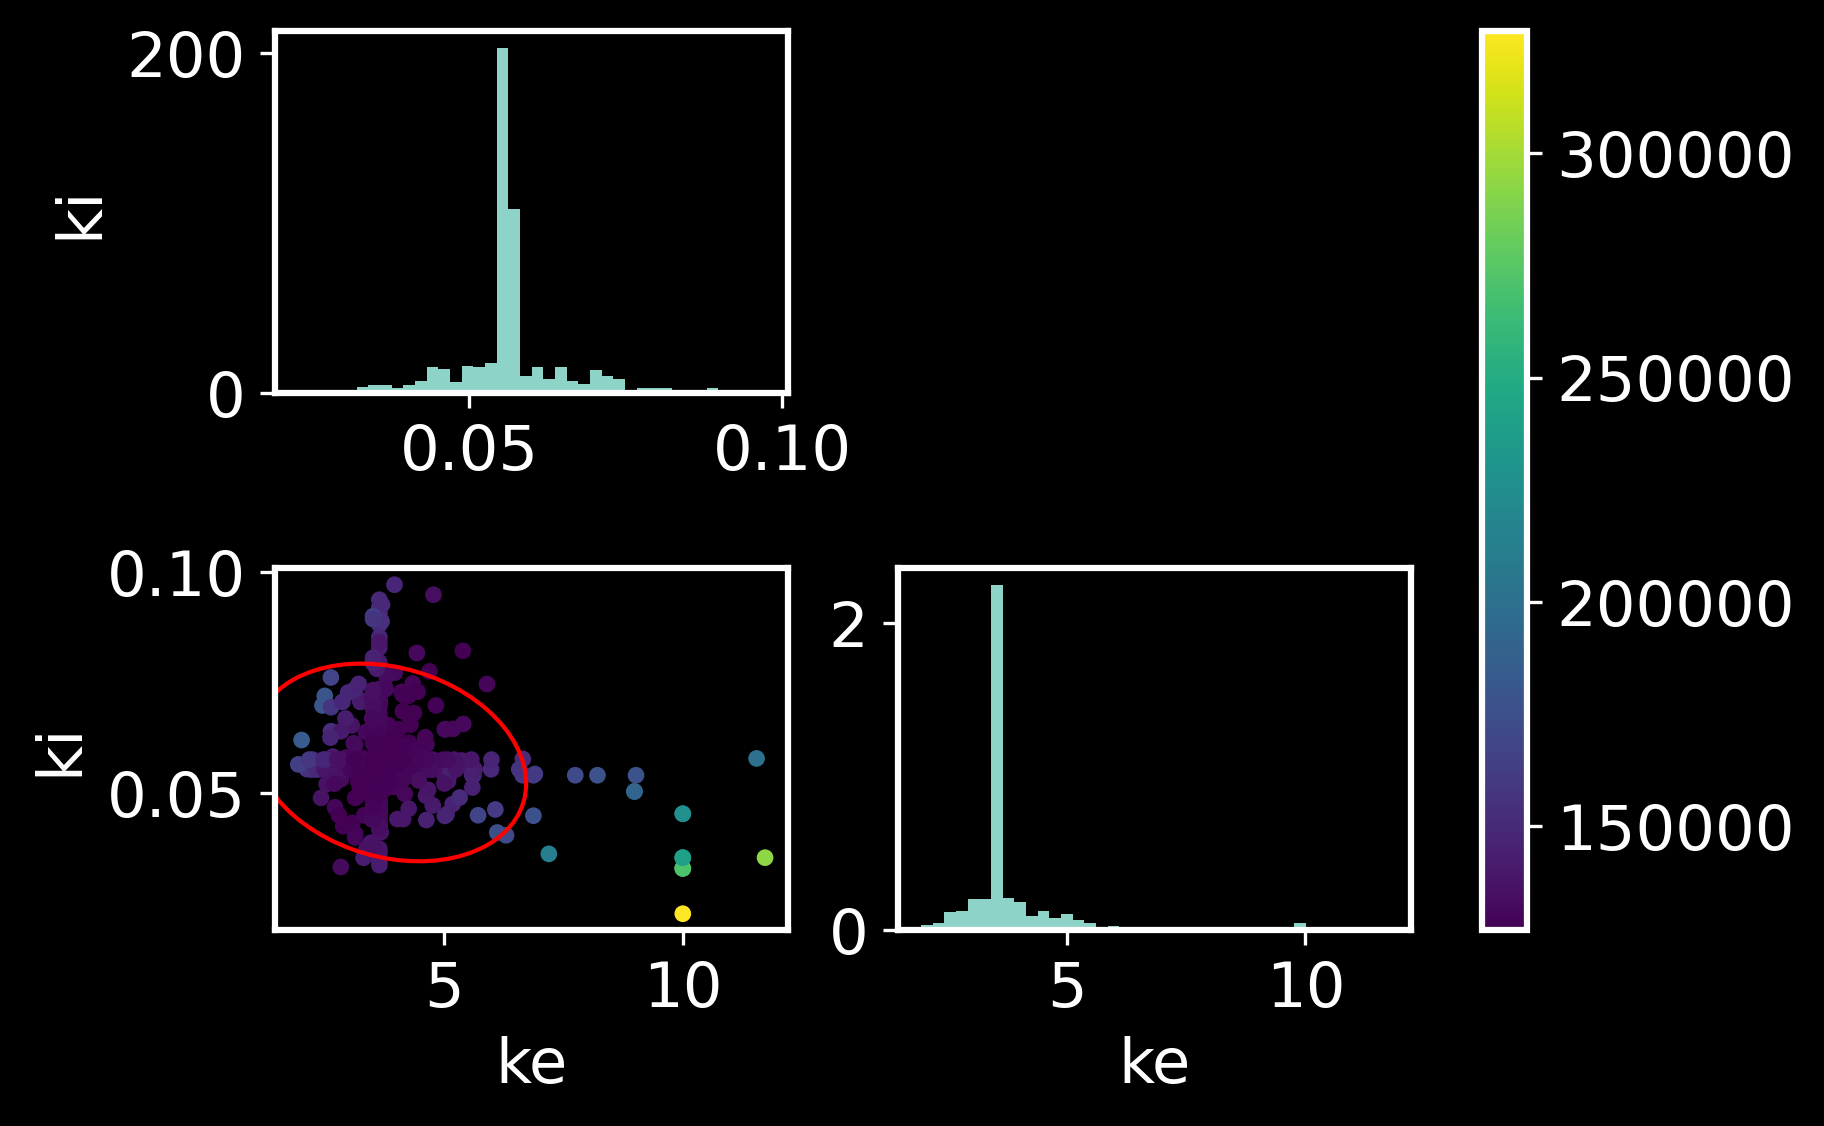

In [7]:
chain.parplot()


In [8]:
chain.report()

Optimizer: MH ran for 601 iterations 
Optimizer arguments: {'stepsize': [0.1, 0.1], 'disp': True, 'mut_rate': 0.5, 'logspace': True, 'niter': 500}
Objective function: ['LL_I_distb']
Objective arguments: [(1,)]
_____________________
Best Parameter Set: [0.057637612831338045, 3.5051336871729117], feval: 126672


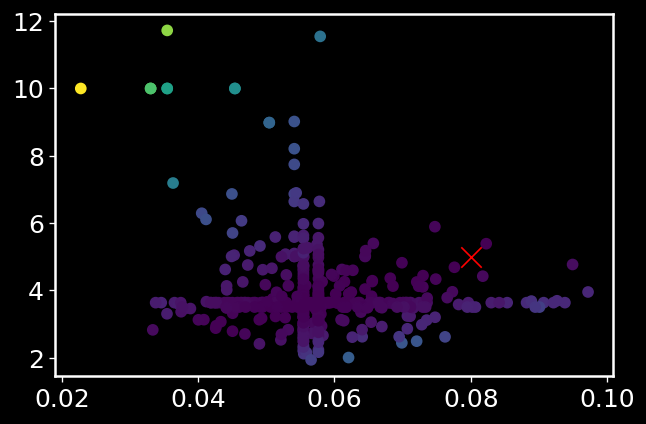

In [23]:
from matplotlib import cm

c = np.linspace(0, 1, len(chain.parchain[:,0]))


evalchain, parchain = chain._OptChain__clear_invalid_values()

viridis = cm.get_cmap('viridis', int(np.ceil(np.max(evalchain))))
c = evalchain




plt.scatter(parchain[:,0],parchain[:,1],c =c , cmap=viridis)
plt.scatter([0.08],[5],color='red',s=150,marker='x')





Text(0, 0.5, 'Ke')

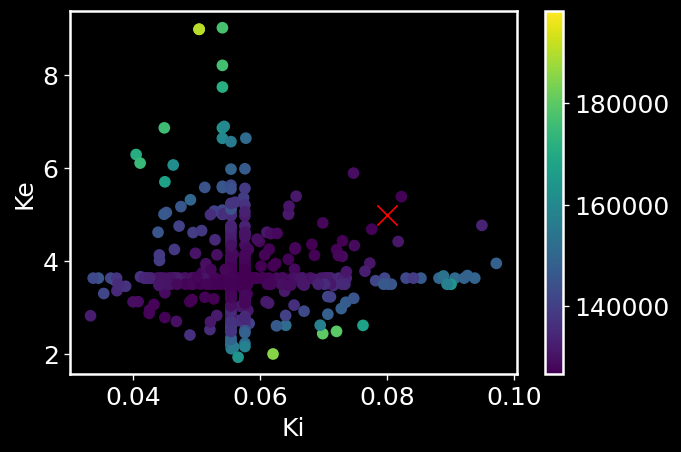

In [10]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

inds = np.where(chain.evalchain<200000)[0]

viridis = cm.get_cmap('viridis', 2000)
colors = chain.evalchain

viridis(colors)

fig,ax = plt.subplots(1,1)
a = ax.scatter(chain.parchain[inds,0]    ,chain.parchain[inds,1] , c = colors[inds] )
ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)


fig.colorbar(a, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

### did ok, but what about multiple objective functions

Simply add them as a list to the run optimization commands

In [11]:

opt.args['LL_acorr'] = (200,'ind','G0')
opt.args['LL_I_distb'] = (1,)
opt.run_optimization(['LL_acorr','LL_I_distb'],'MH',stepsize=[.05,.05],disp=True,mut_rate=.5,logspace=True,niter=500)

Burning in....
current iteration: 50 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126821.776682
current iteration: 100 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126821.776682
current iteration: 150 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126821.776682
current iteration: 200 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126821.776682
current iteration: 250 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126791.403475
current iteration: 300 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126771.754432
current iteration: 350 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | best evaulation: 126771.754432
current iteration: 400 out of 500 | best_parameters: [-1.1708839528400563, 0.632031500423226] | b

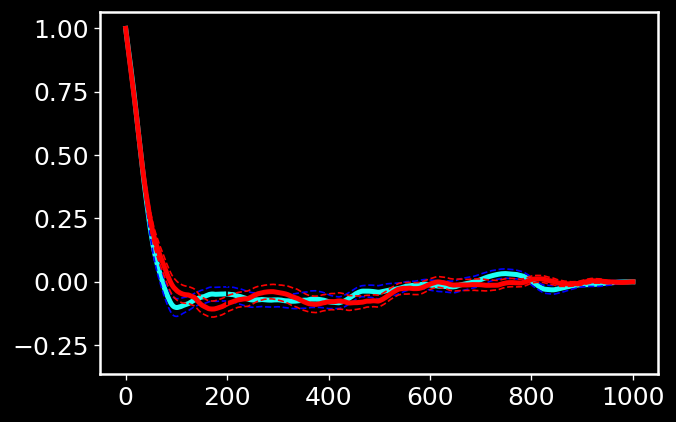

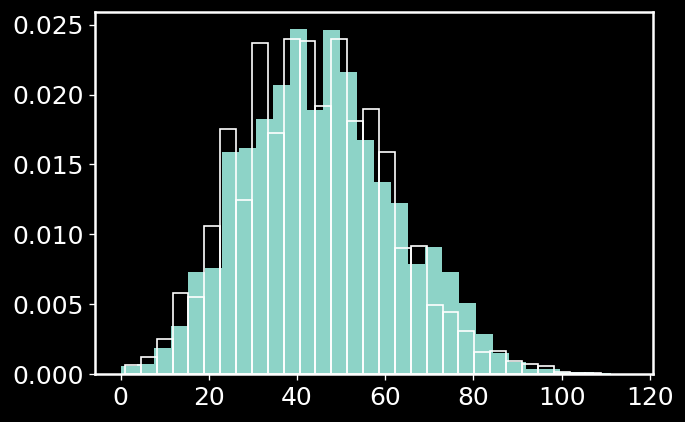

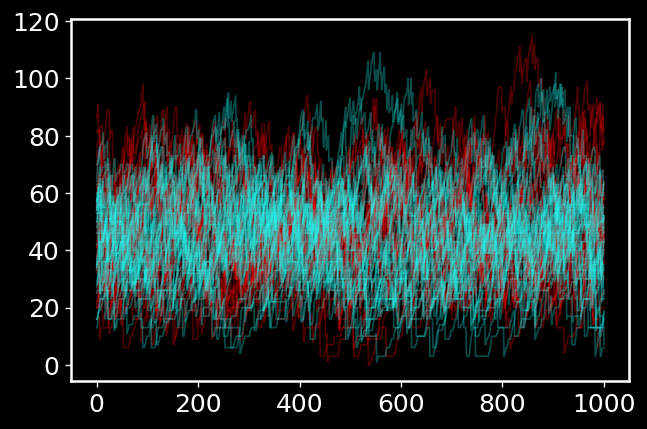

In [25]:
chain_2obj = opt.chain
intensity = opt.intensity_fun([.08,5])

LL = opt.combined_objective([.08,5],['LL_acorr','LL_I_distb'],opt.intensity_fun)

LL2 = opt.combined_objective(chain_2obj.bestpar,['LL_acorr','LL_I_distb'],opt.intensity_fun)


fit_acorr,fit_acorr_error = opt.autocorrelation_fun(intensity)
fit_acorr = np.mean(fit_acorr[0],axis=1)

plt.plot(fit_acorr,'#1cfff7',lw=3)
plt.plot(fit_acorr-fit_acorr_error[0],'b--')
plt.plot(fit_acorr+fit_acorr_error[0],'b--')


plt.plot(np.mean(opt.data_obj.acorr[0],axis=1),'r',lw=3)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) -opt.data_obj.acorr_err[0] ,'r--',lw=1)
plt.plot(np.mean(opt.data_obj.acorr[0],axis=1) +opt.data_obj.acorr_err[0] ,'r--',lw=1)

plt.plot([200,200],[-.3,1],'k--')

plt.figure()
int_hist = opt.intensity_distribution(intensity,bins = sim_data.histogram_bins)
counts1, bins = np.histogram(intensity,density=True,bins=30)
plt.hist(bins[:-1], bins, weights=counts1)

counts2, bins = np.histogram(sim_data.intensity_vec,density=True,bins=30)
plt.hist(bins[:-1], bins, weights=counts2,fill=False)

plt.figure()
plt.plot(intensity[0],'r',alpha=.3)
plt.plot(sim_data.intensity_vec[0],'#1cfff7',alpha=.3)

Text(0, 0.5, 'Ke')

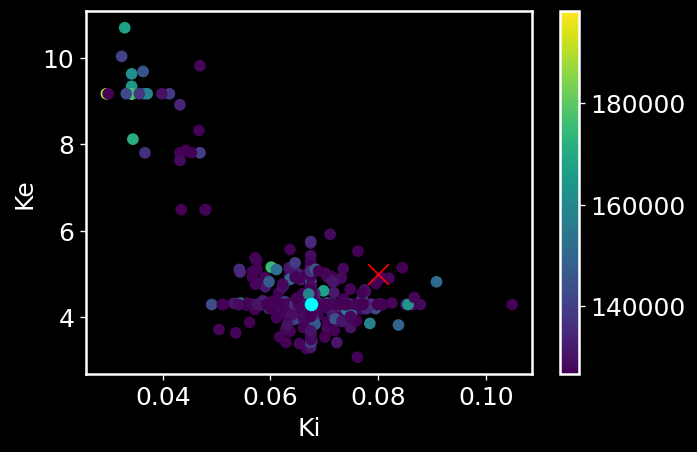

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 200000)


inds = np.where(chain.evalchain<200000)[0]



fig,ax = plt.subplots(1,1)
b = ax.scatter(chain_2obj.parchain[inds,0],chain_2obj.parchain[inds,1], c = colors[inds])
a = ax.scatter([0.08],[5],color='red',s=150,marker='x',vmin=0, vmax=2000)
a = ax.scatter([chain_2obj.bestpar[0]],[chain_2obj.bestpar[1]],color='cyan',s=50,marker='o',vmin=0, vmax=2000)

fig.colorbar(b, ax=ax)
ax.set_xlabel('Ki')
ax.set_ylabel('Ke')

C:\Users\willi\Documents\GitHub\rSNAPsim\rsnapsim\TranslationOptimization.py:855: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


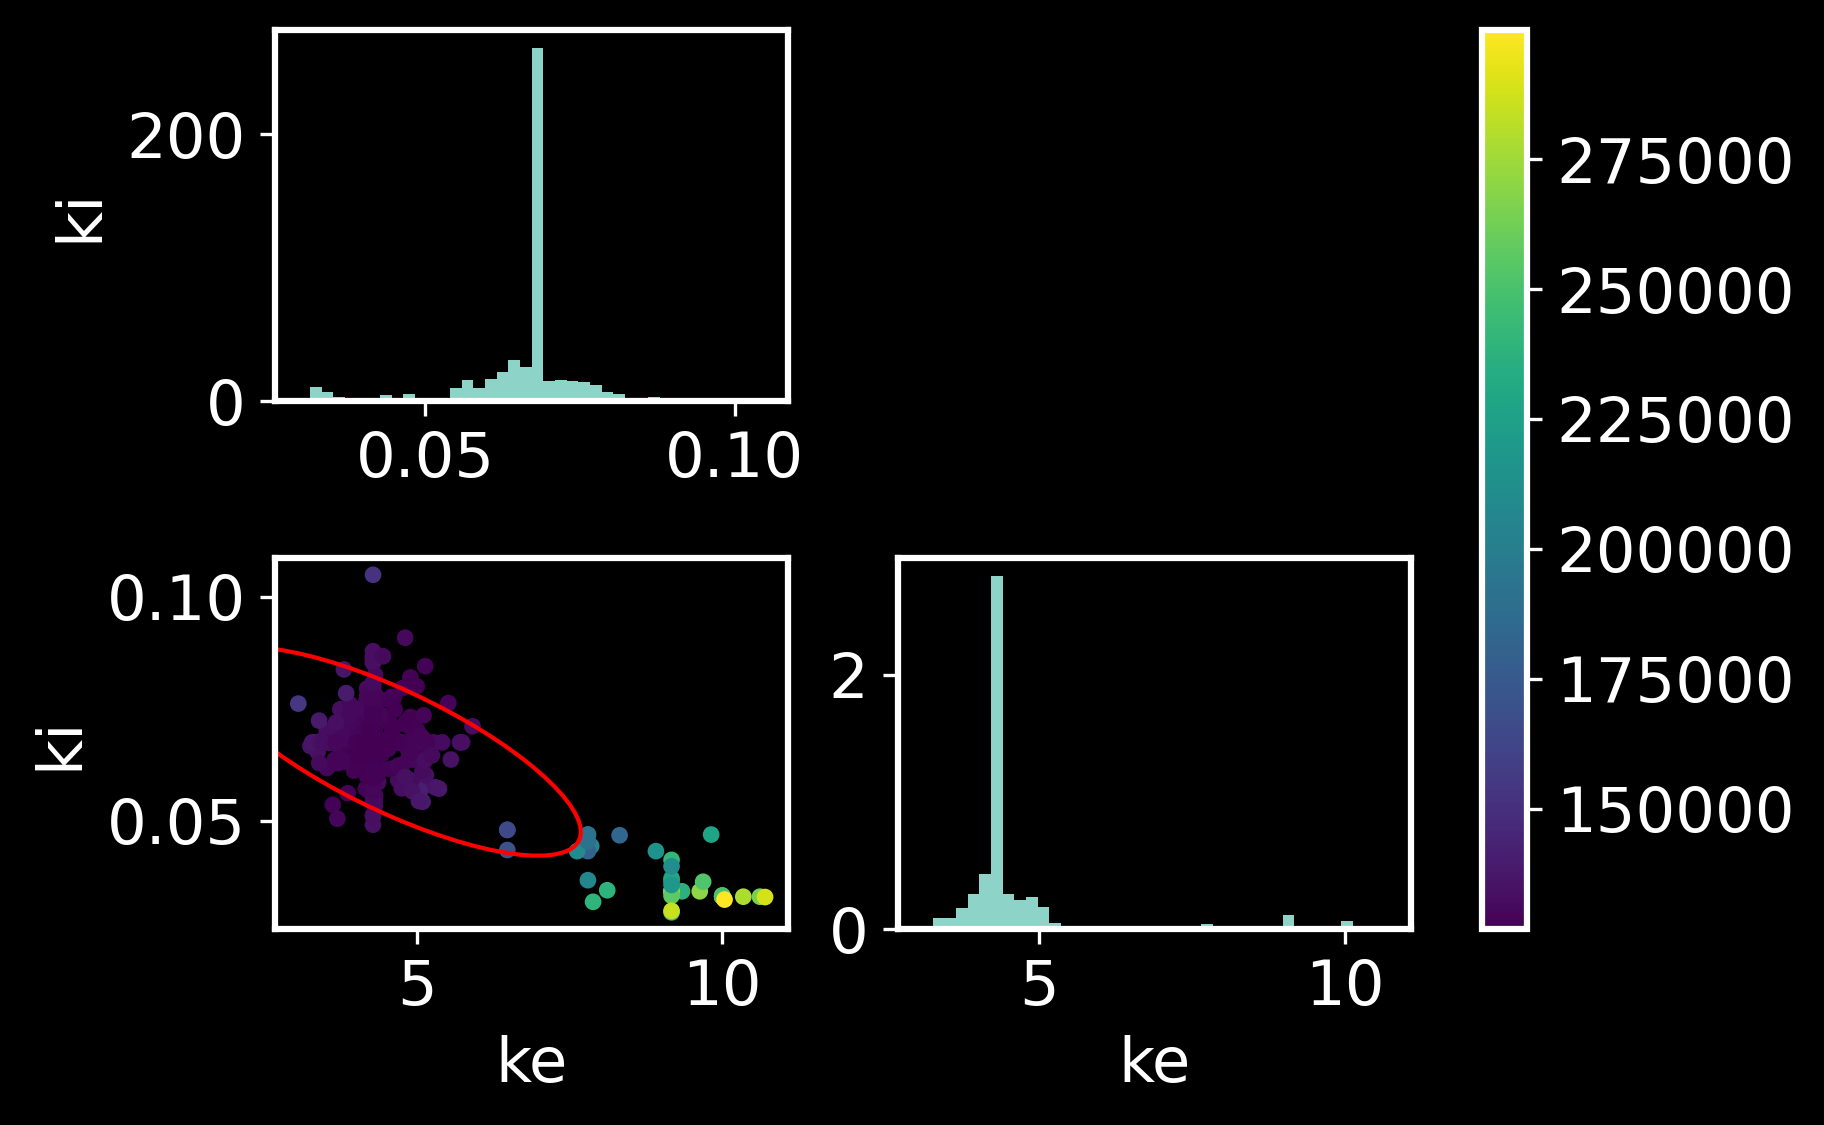

In [15]:
chain_2obj.parplot()

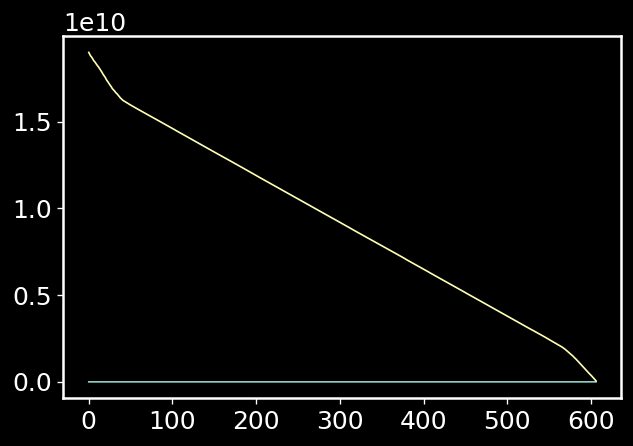

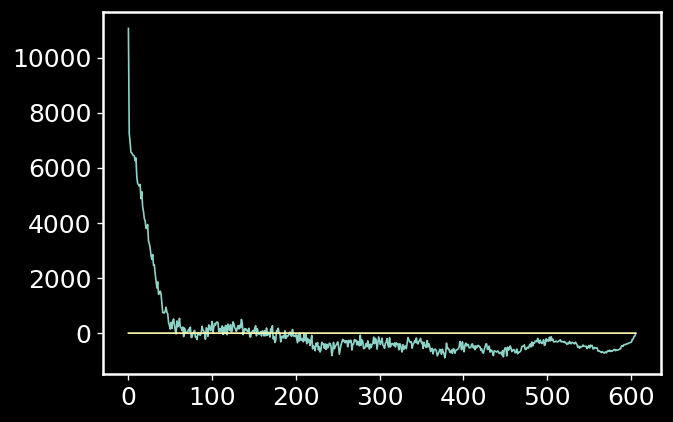

In [29]:
plt.figure()
chain_2obj.check_objfun_convergence()
plt.plot(chain_2obj.objfun_acc)

plt.figure()
chain_2obj.check_parameter_convergence()
plt.plot(chain_2obj.par_acc)

acceptance rate: 0.034826


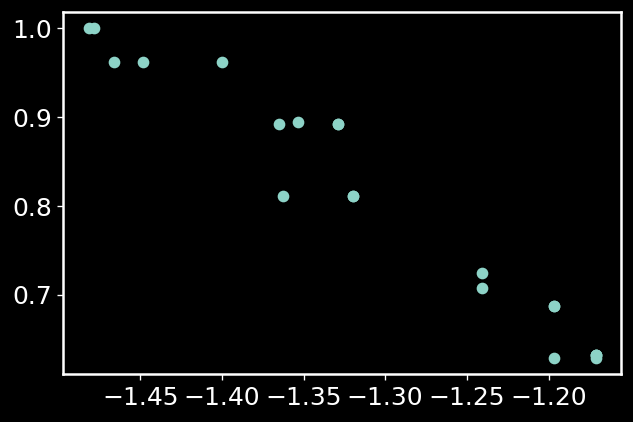

In [17]:
plt.figure()
print('acceptance rate: %f' % (chain_2obj.accepted/chain_2obj.iterations))
plt.scatter(chain_2obj.accepted_parchain[:,0],chain_2obj.accepted_parchain[:,1])

In [26]:
def get_acc2(data, trunc=False):
    N = len(data)
    fvi = np.fft.fft(data, n=2*N)
    acf = fvi*np.conjugate(fvi)
    acf = np.fft.ifft(acf)
    acf = np.real(acf[:N])/float(N)
    if trunc:
        acf[acf < 0]=0
        for i in range(1, len(acf)):
            if acf[i] > acf[i-1]:
                acf[i] = acf[i-1]
    return acf    


p = chain_2obj.parchain
acorr = get_acc2(  (p[:,1] - np.mean(p[:,1]))  / np.var(p[:,1])  )


In [27]:
acorr.shape

(607,)

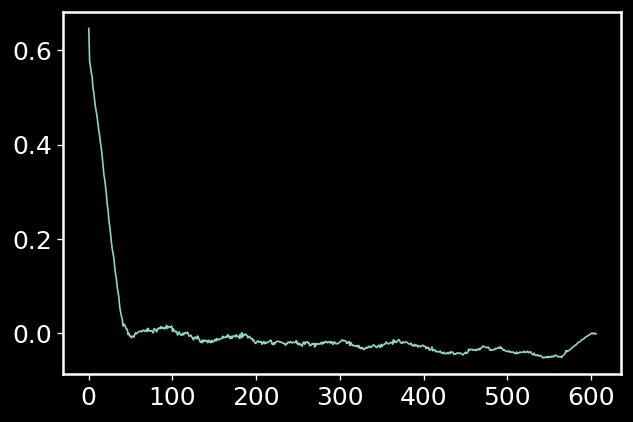

In [28]:
plt.plot(acorr)

In [21]:
chain_2obj.report()

Optimizer: MH ran for 603 iterations 
Optimizer arguments: {'stepsize': [0.05, 0.05], 'disp': True, 'mut_rate': 0.5, 'logspace': True, 'niter': 500}
Objective function: ['LL_acorr', 'LL_I_distb']
Objective arguments: [(200, 'ind', 'G0'), (1,)]
_____________________
Best Parameter Set: [0.06747082913767323, 4.285796051795722], feval: 126771
